In [317]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import random
import datetime
from scipy import stats
import plotly.express as px
import seaborn as sns
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,recall_score,f1_score
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE






In [269]:
!pip install ucimlrepo
#!pip install --upgrade seaborn matplotlib
!pip install scipy
!pip install xgboost
!pip install imbalanced-learn



# Reading the data

In [318]:
from ucimlrepo import fetch_ucirepo

# Fetch the Adult dataset
dataset = fetch_ucirepo('adult')
#print(dataset)
# Access data 
actual_data=dataset.data.features # give dataset except target
target = dataset.data.targets
# Convert to pandas DataFrame
df = pd.DataFrame(data=actual_data, columns=dataset.headers)
df["income"]=target

# Display the first few rows of the DataFrame
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


# copying the data in df1

In [319]:
df1=df.copy()

# cleaning income column

In [320]:
df1['income']=df1['income'].replace('<=50K.','<=50K')
df1['income']=df1['income'].replace('>50K.','>50K')

# Classifying the age
child:0-12
Teen: Ages 13-19
Young Adult: Ages 20–34
Adult: Ages 35–60
Senior: Ages 61–100


In [321]:
# Define bins and labels for age categories
bins = [0, 13, 20, 35, 61, 100]  # Age intervals
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']  # Corresponding labels

# Use pd.cut to categorize the age into groups
df1['age_group'] = pd.cut(df1['age'], bins=bins, labels=labels, right=False)

# Display the DataFrame
print(df1)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

# Classifying education:
Elementary: Preschool,1st Grade to 4th Grade
Middle School: 5th Grade to 8th Grade
High School : 9th Grade to 12th Grade


In [322]:
# Function to categorize grade levels
def categorize_grade(grade):
    if grade in ['Preschool', '1st-4th']:
        return 'Elementary'
    elif grade in ['5th-6th', '7th-8th']:
        return 'Middle School'
    elif grade in ['9th', '10th', '11th', '12th']:
        return 'Not HS-grad'
    else:
        return grade
        
# Apply the function to categorize grade levels
df1['education_category'] = df1['education'].apply(categorize_grade)
# Show the result
print(df1)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

# replacing invalid entries to null

In [323]:
df1['workclass'].replace(['?', ' '], np.nan, inplace=True)
df1['occupation'].replace(['?', ' '], np.nan, inplace=True)
df1['native-country'].replace(['?', ' '], np.nan, inplace=True)


# replacing workclass values with 0 for never-worked

In [324]:
df1.loc[df1['workclass'] == 'Never-worked', 'hours-per-week'] = 0

# Dropping the duplicate Rows(52 of them)

In [325]:
duplicate_count = df1.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 52


In [326]:
df1 = df1.drop_duplicates()

In [327]:
df1.shape

(48790, 17)

# Dropping the uncessary columns

In [328]:
# dropping the unnecessary columns: fnlwgt(as it is a cencus adjustment value), education(as we have education number)
columns_to_drop = ['fnlwgt', 'education','capital-gain', 'capital-loss', 'education-num','age'] 
#Dropping the specified columns
df1 = df1.drop(columns=columns_to_drop)



In [329]:

df1.shape

(48790, 11)

# Imputing Missing value in workclass using random forest

In [330]:
df1['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', nan, 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [331]:
 df1['workclass'].value_counts()

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [332]:
df1['workclass'].isnull().sum()

2795

In [333]:
df1['occupation'].isnull().sum()

2805

In [334]:
df1.dtypes

workclass               object
marital-status          object
occupation              object
relationship            object
race                    object
sex                     object
hours-per-week           int64
native-country          object
income                  object
age_group             category
education_category      object
dtype: object

# Label encoding

In [335]:
#from sklearn.preprocessing import LabelEncoder

# columns that we are encoding: 
columns_to_encode = ['age_group','workclass', 'marital-status', 'occupation', 'relationship','race', 
                     'sex', 'native-country', 'income' ,'education_category'] 
# Initialize the LabelEncoder
le = LabelEncoder()

# Dictionary to store mappings for each column
label_mappings = {}

# Apply label encoding and save mappings
for col in columns_to_encode:
    df1[col] = le.fit_transform(df1[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the mapping of each encoded column
for col, mapping in label_mappings.items():
    print(f"Mapping for {col}: {mapping}")

Mapping for age_group: {'Adult': 0, 'Senior': 1, 'Teen': 2, 'Young Adult': 3}
Mapping for workclass: {'Federal-gov': 0, 'Local-gov': 1, 'Never-worked': 2, 'Private': 3, 'Self-emp-inc': 4, 'Self-emp-not-inc': 5, 'State-gov': 6, 'Without-pay': 7, nan: 8}
Mapping for marital-status: {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
Mapping for occupation: {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13, nan: 14}
Mapping for relationship: {'Husband': 0, 'Not-in-family': 1, 'Other-relative': 2, 'Own-child': 3, 'Unmarried': 4, 'Wife': 5}
Mapping for race: {'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'Black': 2, 'Other': 3, 'White': 4}
Mapping for sex: {'F

# imputing missing values in workclass using random forest classifier

In [336]:
df1['workclass'].value_counts()

workclass
3    33860
5     3861
1     3136
8     2795
6     1981
4     1694
0     1432
7       21
2       10
Name: count, dtype: int64

In [337]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split



# Separate rows with and without missing values in 'workclass', 8 is mapping to null
df_missing =  df1[df1['workclass'] == 8]
df_not_missing =  df1[df1['workclass'] != 8]


# imputing missing values in workclass
# Define features and target
X =  df_not_missing.drop(columns=['workclass'])   # Features
y = df_not_missing['workclass'] # Target variable (workclass)


# Split the non-missing data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Use the trained model to predict the 'workclass' for rows with missing values
X_missing = df_missing.drop(columns=['workclass'])  # Features for rows with missing values
df_missing['workclass'] = rf.predict(X_missing)

# Combine the data back together
df_imputed= pd.concat([df_not_missing, df_missing])

# Display the imputed DataFrame
#print(df_imputed)
df_imputed['workclass'].value_counts()
df1=df_imputed.copy()

C:\Users\srini\AppData\Local\Temp\ipykernel_20016\1209316205.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing['workclass'] = rf.predict(X_missing)


In [338]:
df1['workclass'].value_counts()

workclass
3    36408
5     3960
1     3242
6     2002
4     1705
0     1441
7       21
2       11
Name: count, dtype: int64

In [339]:
df1['workclass'].isnull().sum()

0

# imputing occupation column using random forest

In [340]:
df1['occupation'].value_counts()

occupation
9     6165
2     6102
3     6082
0     5606
11    5501
7     4919
6     3017
14    2805
13    2355
5     2071
4     1485
12    1445
10     982
8      240
1       15
Name: count, dtype: int64

In [341]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split



# Separate rows with and without missing values in 'occupation', 14 is mapping to null
df_missing =  df1[df1['occupation'] == 14]
df_not_missing =  df1[df1['occupation'] != 14]


# imputing missing values in occupation
# Define features and target
X =  df_not_missing.drop(columns=['occupation'])   # Features
y = df_not_missing['occupation'] # Target variable (occupation)


# Split the non-missing data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Use the trained model to predict the 'workclass' for rows with missing values
X_missing = df_missing.drop(columns=['occupation'])  # Features for rows with missing values
df_missing['occupation'] = rf.predict(X_missing)

# Combine the data back together
df_imputed = pd.concat([df_not_missing, df_missing])

# Display the imputed DataFrame
#print(df_imputed)
df_imputed['occupation'].value_counts()
df1=df_imputed.copy()

C:\Users\srini\AppData\Local\Temp\ipykernel_20016\2138698977.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing['occupation'] = rf.predict(X_missing)


In [342]:
df1['occupation'].value_counts()

occupation
2     6471
9     6375
3     6267
0     6149
11    5840
7     5489
6     3121
13    2540
5     2221
4     1538
12    1475
10    1015
8      274
1       15
Name: count, dtype: int64

## Oversampling >50k

In [343]:
df3=df1.copy()
df3


,workclass,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,age_group,education_category
0,6,4,0,1,4,1,40,38,0,0,2
1,5,2,3,0,4,1,13,38,0,0,2
2,3,0,5,1,4,1,40,38,0,0,5
3,3,2,5,0,2,1,40,38,0,0,8
4,3,2,9,5,2,0,40,4,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...
48682,3,2,9,0,4,1,14,38,0,1,10
48769,3,4,7,3,4,0,30,38,0,3,10
48800,3,2,7,0,4,1,25,1,0,1,5
48812,3,2,13,0,4,1,20,38,0,1,1


In [362]:
df1=df3.copy()

In [363]:
df1

,workclass,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,age_group,education_category
0,6,4,0,1,4,1,40,38,0,0,2
1,5,2,3,0,4,1,13,38,0,0,2
2,3,0,5,1,4,1,40,38,0,0,5
3,3,2,5,0,2,1,40,38,0,0,8
4,3,2,9,5,2,0,40,4,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...
48682,3,2,9,0,4,1,14,38,0,1,10
48769,3,4,7,3,4,0,30,38,0,3,10
48800,3,2,7,0,4,1,25,1,0,1,5
48812,3,2,13,0,4,1,20,38,0,1,1


In [364]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming X is your DataFrame with independent variables
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calculate_vif(df1.drop(columns = ['income']))
print(vif_df)

              Feature        VIF
0           workclass   8.116530
1      marital-status   4.395577
2          occupation   3.116816
3        relationship   2.696015
4                race  17.179499
5                 sex   4.463508
6      hours-per-week  10.872421
7      native-country  24.205109
8           age_group   2.140256
9  education_category   4.368620


In [365]:
df1.columns

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'hours-per-week', 'native-country', 'income', 'age_group',
       'education_category'],
      dtype='object')

In [366]:
#Since hours-per-week, native country and race has VIF > 10 indicating high colinearity,
#we can keep hours-per-week and remove the other two as hours per week is more meaningful feature for the salary prediction(to this domain). 
df1  = df1.drop(columns = ['native-country', 'race'])


In [367]:
print(df1.columns)

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'sex',
       'hours-per-week', 'income', 'age_group', 'education_category'],
      dtype='object')



Also we have workclass with VIF > 5, but <10 indicating medium colinearity.
Given that "hours per week" has a VIF of 12, which is significantly high, you might consider removing it first. However, if it is more predictive 
than "workclass," we dicided to evaluate the impact on our model's performance after removing either feature. 
Running experiments to see how our model behaves with and without each feature can help make the most informed decision.

In [368]:
df_without_workclass = df1.drop(columns = ['workclass'])
df_without_hrsPerWk = df1.drop(columns = ['hours-per-week'])

In [386]:
df1 = df_without_workclass.copy()

In [379]:
df1=df_without_hrsPerWk.copy()

In [387]:
df1 


,marital-status,occupation,relationship,sex,hours-per-week,income,age_group,education_category
0,4,0,1,1,40,0,0,2
1,2,3,0,1,13,0,0,2
2,0,5,1,1,40,0,0,5
3,2,5,0,1,40,0,0,8
4,2,9,5,0,40,0,3,2
...,...,...,...,...,...,...,...,...
48682,2,9,0,1,14,0,1,10
48769,4,7,3,0,30,0,3,10
48800,2,7,0,1,25,0,1,5
48812,2,13,0,1,20,0,1,1


In [388]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Assuming 'income' is the target variable with values '>50K' and '<=50K'
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after oversampling
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

# Convert the resampled data back into a DataFrame
X_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_train_resampled, columns=['income'])

# Combine the features and target into a single DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)


Before SMOTE: income
0    29659
1     9373
Name: count, dtype: int64
After SMOTE: income
0    29659
1    29659
Name: count, dtype: int64


In [389]:
df1=df_resampled.copy()

In [390]:
df1

,marital-status,occupation,relationship,sex,hours-per-week,age_group,education_category,income
0,4,2,3,1,40,3,5,0
1,2,2,0,1,45,3,10,0
2,4,11,3,0,25,3,10,0
3,2,13,0,1,55,0,5,1
4,4,8,2,0,40,3,7,0
...,...,...,...,...,...,...,...,...
59313,2,9,5,0,20,0,2,1
59314,2,3,0,1,40,3,2,1
59315,2,11,0,1,60,0,2,1
59316,2,0,5,0,31,2,10,1


In [391]:
models=[]
models.append(('XGBClassifier',XGBClassifier()))
models.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
models.append(('Naive Bayes',GaussianNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=3)))
models.append(('RandomForestClassifier',RandomForestClassifier()))
models.append(('DecisionTreeClassifier',DecisionTreeClassifier()))

X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models:
    print(name,model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test,y_pred))
   
    print("accuracy: ", accuracy_score(y_test, y_pred))
    
    print("precision: ", precision_score(y_test, y_pred) )   
   
    print("recall: ", recall_score(y_test, y_pred))
    
    print("f1score: ", f1_score(y_test, y_pred))
    print('\n')
    print('\n')
    

XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Confusion Matrix: 
[[4683 1231]
 [ 816 5134]]
accuracy:  0.8274612272420768
precision:  0.806598586017282
recall:  0.8628571428571429
f1score:  0.8337799431587495




LogisticRegression LogisticRegression(max_iter=1000)

Confus

In [378]:
models=[]
models.append(('XGBClassifier',XGBClassifier()))
#models.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
#models.append(('Naive Bayes',GaussianNB()))
# models.append(('KNN',KNeighborsClassifier(n_neighbors=3)))
# models.append(('RandomForestClassifier',RandomForestClassifier()))
# models.append(('DecisionTreeClassifier',DecisionTreeClassifier()))

X = df_without_workclass.drop(columns=['income'])  # Features
y = df_without_workclass['income']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models:
    print(name,model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test,y_pred))
   
    print("accuracy: ", accuracy_score(y_test, y_pred))
    
    print("precision: ", precision_score(y_test, y_pred) )   
   
    print("recall: ", recall_score(y_test, y_pred))
    
    print("f1score: ", f1_score(y_test, y_pred))
    print('\n')
    print('\n')
    

XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Confusion Matrix: 
[[6806  644]
 [ 969 1339]]
accuracy:  0.8346997335519574
precision:  0.6752395360564801
recall:  0.580155979202773
f1score:  0.6240969470985784






In [251]:
df1=df_resampled.copy()

In [252]:
df1.shape

(59318, 11)

#  feature selection after oversampling

In [253]:
df1.corr()['income'].sort_values(ascending=False)

income                1.000000
hours-per-week        0.270228
sex                   0.256336
race                  0.089209
occupation            0.050414
native-country        0.016366
workclass            -0.034073
education_category   -0.157748
marital-status       -0.277167
relationship         -0.317458
age_group            -0.344127
Name: income, dtype: float64

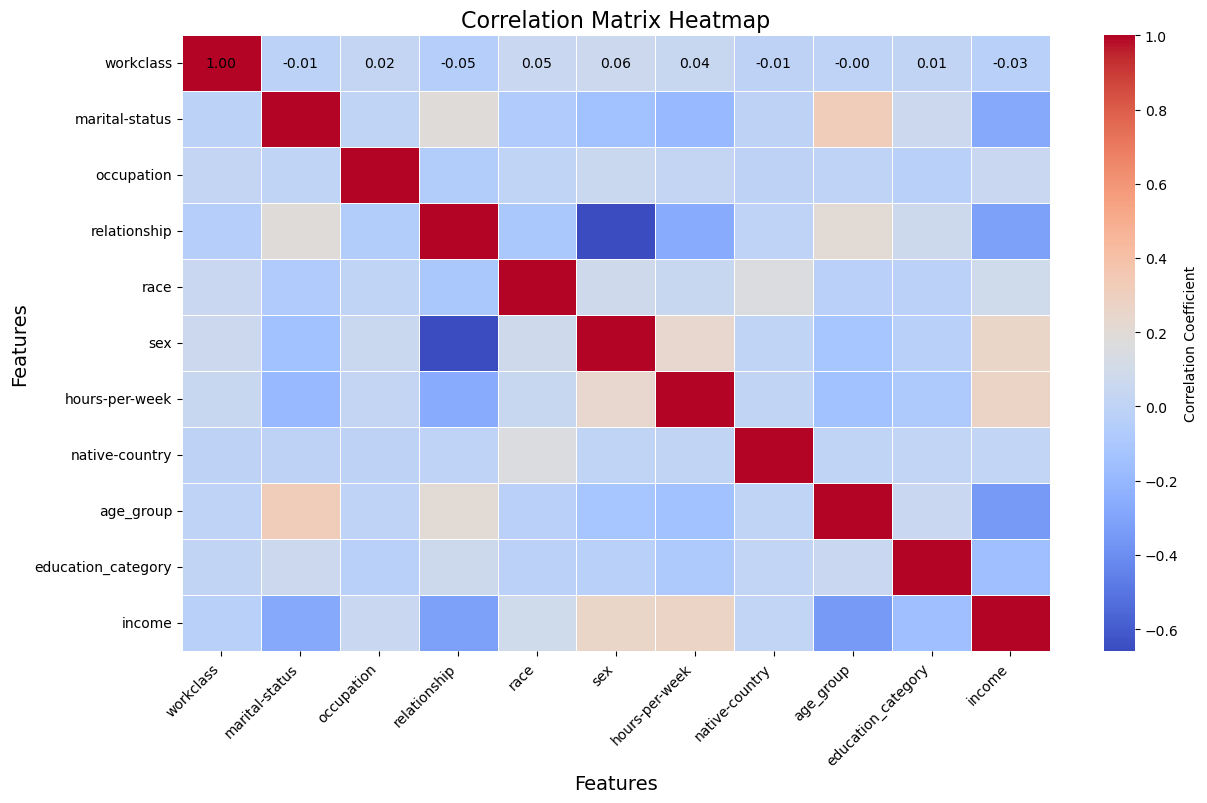

In [189]:
# Compute the correlation matrix
correlation_matrix = df1.corr()
# Create the heatmap
plt.figure(figsize=(14, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            annot_kws={"size": 10, "color": "black"},  # Customize font size and color
            fmt=".2f",  # Display values with 2 decimal places
            cbar_kws={'label': 'Correlation Coefficient'}  # Add label to color bar
           )

# Set the axis labels and title
plt.title("Correlation Matrix Heatmap", fontsize=16)  # Set title and size
plt.xlabel("Features", fontsize=14)  # X-axis label
plt.ylabel("Features", fontsize=14)  # Y-axis label

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for readability

# Show the heatmap
plt.show()

In [191]:
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder, StandardScaler


X = df1.drop('income',axis=1)
y = df1['income']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally scale numerical features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

print(X_train)

       workclass  marital-status  occupation  relationship  race  sex  \
8850           3               4           6             3     2    0   
35750          6               2           9             0     1    1   
26904          3               3           2             1     1    1   
20016          1               4           9             3     1    1   
52602          3               2           2             0     4    1   
...          ...             ...         ...           ...   ...  ...   
54343          3               2           3             0     4    1   
38158          6               0          10             1     4    1   
860            3               0           7             1     4    1   
15795          3               4          12             1     4    0   
56422          3               1           3             4     4    0   

       hours-per-week  native-country  age_group  education_category  
8850               40              38          3    

In [200]:
#Feature selection for chi2
# Initialize SelectKBest with all features
selector = SelectKBest(score_func=chi2, k=X.shape[1])  # Set k=X.shape[1] to get all feature scores
selector.fit(X, y)

# Get feature scores and p-values
chi2_scores = selector.scores_
p_values = selector.pvalues_

# Ensure scores and p-values are numeric
chi2_scores = pd.to_numeric(chi2_scores, errors='coerce')
p_values = pd.to_numeric(p_values, errors='coerce')

# Create a DataFrame with features and their scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
    
})

#Sort the features by Chi-square scores in descending order
#sorted_features = feature_scores.sort_values(by='Chi2 Score', ascending=False)
#feature_scores['Chi2_Score'], feature_scores['p-value']
print(feature_scores.sort_values(by='Chi2 Score',ascending=False))

              Feature    Chi2 Score        p-value
6      hours-per-week  15235.602817   0.000000e+00
3        relationship  13419.339518   0.000000e+00
8           age_group  12301.509890   0.000000e+00
1      marital-status   3302.079407   0.000000e+00
9  education_category   2624.451990   0.000000e+00
5                 sex   1067.096894  4.680430e-234
2          occupation    399.220059   8.141762e-89
4                race     82.493315   1.060281e-19
0           workclass     28.677688   8.548298e-08
7      native-country     16.078648   6.076533e-05


#anova

In [206]:
from sklearn.feature_selection import SelectKBest, f_classif


# If you want to select all features, use 'all'
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' will select all features
selector.fit(X, y)

# Get feature scores and p-values
anova_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with features and their scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA Score': anova_scores,
    'p-value': p_values
})

# Sort the features by ANOVA score in descending order
sorted_features = feature_scores.sort_values(by='ANOVA Score', ascending=False)
print(sorted_features)

              Feature  ANOVA Score        p-value
8           age_group  7967.979509   0.000000e+00
3        relationship  6647.814926   0.000000e+00
1      marital-status  4935.926566   0.000000e+00
6      hours-per-week  4672.650357   0.000000e+00
5                 sex  4171.641967   0.000000e+00
9  education_category  1513.711958   0.000000e+00
4                race   475.832831  4.471859e-105
2          occupation   151.140285   1.076514e-34
0           workclass    68.942665   1.034772e-16
7      native-country    15.891919   6.714469e-05


# Wrapper Method: Recursive Feature Elimination (RFE):

In [211]:
# Increase max_iter to allow more iterations
model = LogisticRegression(max_iter=5000)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X, y)

# Get the selected features
#print("Selected Features: ", X.columns[fit.support_])


# Get the feature rankings
ranking = rfe.ranking_

# Create a DataFrame to display feature names and their ranks
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Rank': ranking
})

# Sort the features by rank (1 = most important)
sorted_feature_ranking = feature_ranking.sort_values(by='Rank',ascending=True)

# Print the ranking
print(sorted_feature_ranking)

              Feature  Rank
1      marital-status     1
3        relationship     1
4                race     1
5                 sex     1
8           age_group     1
0           workclass     2
9  education_category     3
6      hours-per-week     4
2          occupation     5
7      native-country     6


# Random forest for feature selection

              Feature  Importance
3        relationship    0.213076
1      marital-status    0.166106
6      hours-per-week    0.154437
2          occupation    0.131883
9  education_category    0.114915
8           age_group    0.075611
0           workclass    0.059101
7      native-country    0.034523
4                race    0.027646
5                 sex    0.022701


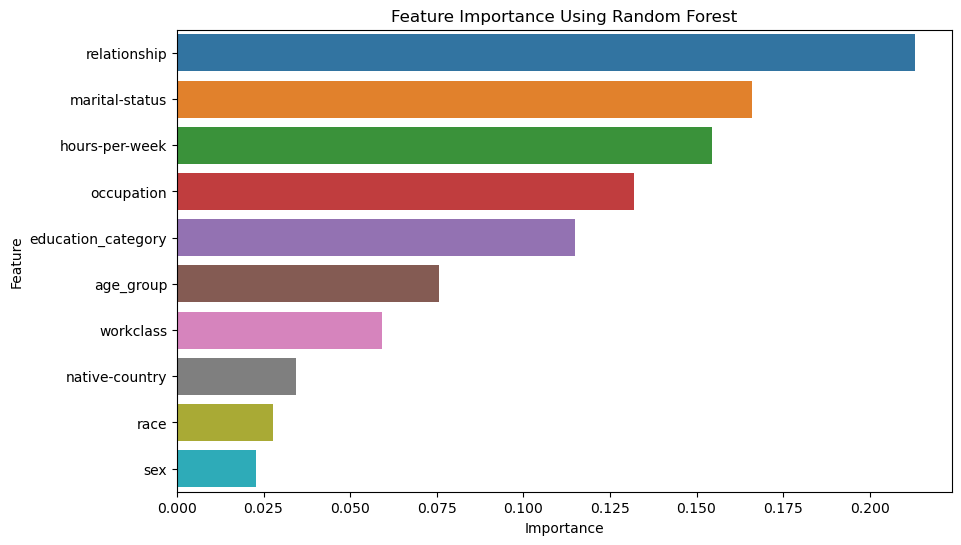

In [218]:


# Assuming df1 is your DataFrame and 'target' is your target column
X = df1.drop('income', axis=1)  # Features
y = df1['income']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a Random Forest Classifier (or Regressor)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importances)

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance Using Random Forest')
plt.show()



#models1.append(('SVM',SVC(kernel='linear')))
#models1.append(('SVM', SVC(kernel='poly', degree=3, coef0=1, gamma='auto')))
for name, model in models:
    print('\n')
    print(name,model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #changing the values into %
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    print("confusion_matrix: \n")
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print("Accuracy: {:.2f}%".format(accuracy))
    print("Precision: {:.2f}%".format(precision))
    print("Recall: {:.2f}%".format(recall))
    print("F1 Score: {:.2f}%".format(f1))
    

# Hyperparameter tuning using GridSearchCV

In [ ]:
# Hyperparameter tuning using GridSearchCV
# Prepare features and target variable
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# List of classifiers and their corresponding parameter grids
models_param_grids = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [XGBoostClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
]
# Loop through models and perform hyperparameter tuning
best_models = []
for param_grid in models_param_grids:
    pipeline = Pipeline([
        ('classifier', param_grid['classifier'][0])
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    # Best model and parameters for the current classifier
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    print(f"Model: {param_grid['classifier'][0].__class__.__name__}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score (Accuracy): {best_score:.4f}")
    # Save the best model from each classifier
    best_models.append((best_model, best_score))
# Evaluate the best models on the test set
for model, score in best_models:
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy for {model.named_steps['classifier'].__class__.__name__}: {test_accuracy:.4f}")

# Hyperparameter tuning using RandomizedSearchCV

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Prepare features and target variable
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# List of classifiers and their corresponding random search parameter distributions
models_param_distributions = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': randint(2, 10)
    },
    {
        'classifier': [XGBoostClassifier()],
        'classifier__n_estimators': randint(50, 200),
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': randint(3, 5),
        'classifier__min_samples_split': randint(2, 10)
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': randint(2, 10)
    }
]
# Loop through models and perform hyperparameter tuning using RandomizedSearchCV
best_models = []
for param_distribution in models_param_distributions:
    pipeline = Pipeline([
        ('classifier', param_distribution['classifier'][0])
    ])
    random_search = RandomizedSearchCV(
        pipeline,
        param_distribution,
        cv=5,
        n_iter=10,  # Number of parameter settings to sample
        n_jobs=-1,
        verbose=1,
        scoring='accuracy',
        random_state=42
    )
    random_search.fit(X_train, y_train)
    # Best model and parameters for the current classifier
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_model = random_search.best_estimator_
    print(f"Model: {param_distribution['classifier'][0].__class__.__name__}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score (Accuracy): {best_score:.4f}")
    # Save the best model from each classifier
    best_models.append((best_model, best_score))
# Evaluate the best models on the test set
for model, score in best_models:
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy for {model.named_steps['classifier'].__class__.__name__}: {test_accuracy:.4f}")

# Features from different selectors along with metrics from various models

In [220]:
df1

,workclass,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,age_group,education_category,income
0,3,4,2,3,4,1,40,38,3,5,0
1,3,2,2,0,4,1,45,25,3,10,0
2,3,4,11,3,4,0,25,38,3,10,0
3,3,2,13,0,4,1,55,38,0,5,1
4,3,4,8,2,4,0,40,12,3,7,0
...,...,...,...,...,...,...,...,...,...,...,...
59313,5,2,9,5,4,0,20,38,0,2,1
59314,3,2,3,0,4,1,40,38,3,2,1
59315,4,2,11,0,4,1,60,38,0,2,1
59316,3,2,0,4,4,0,31,38,2,10,1


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,education_category,hours-per-week_category
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Adult,Bachelors,Full-time
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Adult,Bachelors,Part-time
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,Adult,HS-grad,Full-time
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,Adult,Not HS-grad,Full-time
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Young Adult,Bachelors,Full-time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K,Adult,Bachelors,Full-time
48838,64,NaN,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K,Senior,HS-grad,Full-time
48839,38,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K,Adult,Bachelors,Over-time
48840,44,Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K,Adult,Bachelors,Full-time


In [221]:

# Sample dataset (replace with your own)
data = df1
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500),
   # "LogisticRegression": LogisticRegression(max_iter=60000),
    "KNN":KNeighborsClassifier(n_neighbors=3),
    "DecisionTreeClassifier":DecisionTreeClassifier()
}

# Feature selection methods
feature_selectors = {
    "Chi-Square": SelectKBest(chi2, k=8),
    "ANOVA": SelectKBest(f_classif, k=8),
    "RFE (Logistic Regression)": RFE(estimator=LogisticRegression(), n_features_to_select=8),
    "Random Forest Importance": RandomForestClassifier()
}

# Dictionary to store metrics for each combination
results = []

# Loop through each feature selection method
for fs_name, fs in feature_selectors.items():
    
    # Apply feature selection
    if fs_name == "Random Forest Importance":
        fs.fit(X_train, y_train)
        feature_importances = np.argsort(fs.feature_importances_)[-8:]  # Selecting top 2 features
        X_train_fs = X_train[:, feature_importances]
        X_test_fs = X_test[:, feature_importances]
    else:
        X_train_fs = fs.fit_transform(X_train, y_train)
        X_test_fs = fs.transform(X_test)

    # Loop through each model
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the result
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

# Create a DataFrame to store results for easy comparison
results_df = pd.DataFrame(results)





F:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
F:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

InvalidIndexError: (slice(None, None, None), array([7, 0, 8, 9, 2, 6, 1, 3], dtype=int64))

In [111]:
df1.columns

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'age_group', 'education_category', 'income'],
      dtype='object')

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE
from sklearn.preprocessing import StandardScaler

# Sample dataset (replace with your own)
data = df1
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of models

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500, solver='liblinear')  # Increase iterations and change solver
}


# Feature selection methods
feature_selectors = {
    "Chi-Square": SelectKBest(chi2, k=12),
    "ANOVA": SelectKBest(f_classif, k=12),
    "RFE (Logistic Regression)": RFE(estimator=LogisticRegression(), n_features_to_select=12),
    "Random Forest Importance": RandomForestClassifier()
}

# Dictionary to store metrics for each combination
results = []

# Loop through each feature selection method
for fs_name, fs in feature_selectors.items():
    
    # Apply feature selection
    if fs_name == "Random Forest Importance":
        fs.fit(X_train, y_train)
        feature_importances = np.argsort(fs.feature_importances_)[-12:]  # Selecting top 8 features
        selected_features = X.columns[feature_importances]  # Store feature names
        X_train_fs = X_train.iloc[:, feature_importances]
        X_test_fs = X_test.iloc[:, feature_importances]
        
    else:
        X_train_fs = fs.fit_transform(X_train, y_train)
        X_test_fs = fs.transform(X_test)
        selected_features = X.columns[fs.get_support()]  # Get selected features

 
    # Optionally scale features for certain models
    scaler = StandardScaler()
    for model_name, model in models.items():
        # Only scale for models that need it
        if model_name in ["Logistic Regression", "Neural Network", "KNN"]:
            X_train_fs_scaled = scaler.fit_transform(X_train_fs)
            X_test_fs_scaled = scaler.transform(X_test_fs)
        else:
            X_train_fs_scaled = X_train_fs
            X_test_fs_scaled = X_test_fs

        # Train the model
        model.fit(X_train_fs_scaled, y_train)
        y_pred = model.predict(X_test_fs_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the result
        results.append({
            'Feature_Selection': fs_name,
            'Selected_Features': ', '.join(selected_features),
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

# Create a DataFrame to store results for easy comparison
results_df = pd.DataFrame(results)
print(results_df)


F:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Feature_Selection  \
0                  Chi-Square   
1                  Chi-Square   
2                  Chi-Square   
3                  Chi-Square   
4                  Chi-Square   
5                  Chi-Square   
6                  Chi-Square   
7                       ANOVA   
8                       ANOVA   
9                       ANOVA   
10                      ANOVA   
11                      ANOVA   
12                      ANOVA   
13                      ANOVA   
14  RFE (Logistic Regression)   
15  RFE (Logistic Regression)   
16  RFE (Logistic Regression)   
17  RFE (Logistic Regression)   
18  RFE (Logistic Regression)   
19  RFE (Logistic Regression)   
20  RFE (Logistic Regression)   
21   Random Forest Importance   
22   Random Forest Importance   
23   Random Forest Importance   
24   Random Forest Importance   
25   Random Forest Importance   
26   Random Forest Importance   
27   Random Forest Importance   

                                    Select

In [113]:
# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results)

# Export to Excel
results_df.to_excel('model_results_12.xlsx', index=False)
print(results_df)

            Feature_Selection  \
0                  Chi-Square   
1                  Chi-Square   
2                  Chi-Square   
3                  Chi-Square   
4                  Chi-Square   
5                  Chi-Square   
6                  Chi-Square   
7                       ANOVA   
8                       ANOVA   
9                       ANOVA   
10                      ANOVA   
11                      ANOVA   
12                      ANOVA   
13                      ANOVA   
14  RFE (Logistic Regression)   
15  RFE (Logistic Regression)   
16  RFE (Logistic Regression)   
17  RFE (Logistic Regression)   
18  RFE (Logistic Regression)   
19  RFE (Logistic Regression)   
20  RFE (Logistic Regression)   
21   Random Forest Importance   
22   Random Forest Importance   
23   Random Forest Importance   
24   Random Forest Importance   
25   Random Forest Importance   
26   Random Forest Importance   
27   Random Forest Importance   

                                    Select

In [117]:
df3= df1.copy()

In [118]:
df3


,workclass,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age_group,education_category,income
0,3,4,2,3,4,1,0,0,40,38,3,5,0
1,3,2,2,0,4,1,0,0,45,25,3,10,0
2,3,4,11,3,4,0,0,0,25,38,3,10,0
3,3,2,13,0,4,1,0,0,55,38,0,5,1
4,3,4,8,2,4,0,0,0,40,12,3,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59313,5,2,9,5,4,0,0,0,20,38,0,2,1
59314,3,2,3,0,4,1,0,0,40,38,3,2,1
59315,4,2,11,0,4,1,0,0,60,38,0,2,1
59316,3,2,0,5,4,0,7298,0,32,38,2,10,1


In [119]:
# dropping the unnecessary columns: fnlwgt(as it is a cencus adjustment value), education(as we have education number)
columns_to_drop = ['capital-gain', 'capital-loss'] 
#Dropping the specified columns
df1 = df1.drop(columns=columns_to_drop)

In [120]:
df3

,workclass,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age_group,education_category,income
0,3,4,2,3,4,1,0,0,40,38,3,5,0
1,3,2,2,0,4,1,0,0,45,25,3,10,0
2,3,4,11,3,4,0,0,0,25,38,3,10,0
3,3,2,13,0,4,1,0,0,55,38,0,5,1
4,3,4,8,2,4,0,0,0,40,12,3,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59313,5,2,9,5,4,0,0,0,20,38,0,2,1
59314,3,2,3,0,4,1,0,0,40,38,3,2,1
59315,4,2,11,0,4,1,0,0,60,38,0,2,1
59316,3,2,0,5,4,0,7298,0,32,38,2,10,1


In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE
from sklearn.preprocessing import StandardScaler

# Sample dataset (replace with your own)
data = df1
X = df1.drop(columns=['income'])  # Features
y = df1['income']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of models

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500, solver='liblinear')  # Increase iterations and change solver
}


# Feature selection methods
feature_selectors = {
    "Chi-Square": SelectKBest(chi2, k=10),
    "ANOVA": SelectKBest(f_classif, k=10),
    "RFE (Logistic Regression)": RFE(estimator=LogisticRegression(), n_features_to_select=10),
    "Random Forest Importance": RandomForestClassifier()
}

# Dictionary to store metrics for each combination
results = []

# Loop through each feature selection method
for fs_name, fs in feature_selectors.items():
    
    # Apply feature selection
    if fs_name == "Random Forest Importance":
        fs.fit(X_train, y_train)
        feature_importances = np.argsort(fs.feature_importances_)[-10:]  # Selecting top 8 features
        selected_features = X.columns[feature_importances]  # Store feature names
        X_train_fs = X_train.iloc[:, feature_importances]
        X_test_fs = X_test.iloc[:, feature_importances]
        
    else:
        X_train_fs = fs.fit_transform(X_train, y_train)
        X_test_fs = fs.transform(X_test)
        selected_features = X.columns[fs.get_support()]  # Get selected features

 
    # Optionally scale features for certain models
    scaler = StandardScaler()
    for model_name, model in models.items():
        # Only scale for models that need it
        if model_name in ["Logistic Regression", "Neural Network", "KNN"]:
            X_train_fs_scaled = scaler.fit_transform(X_train_fs)
            X_test_fs_scaled = scaler.transform(X_test_fs)
        else:
            X_train_fs_scaled = X_train_fs
            X_test_fs_scaled = X_test_fs

        # Train the model
        model.fit(X_train_fs_scaled, y_train)
        y_pred = model.predict(X_test_fs_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the result
        results.append({
            'Feature_Selection': fs_name,
            'Selected_Features': ', '.join(selected_features),
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

# Create a DataFrame to store results for easy comparison
results_df = pd.DataFrame(results)
print(results_df)


F:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Feature_Selection  \
0                  Chi-Square   
1                  Chi-Square   
2                  Chi-Square   
3                  Chi-Square   
4                  Chi-Square   
5                  Chi-Square   
6                  Chi-Square   
7                       ANOVA   
8                       ANOVA   
9                       ANOVA   
10                      ANOVA   
11                      ANOVA   
12                      ANOVA   
13                      ANOVA   
14  RFE (Logistic Regression)   
15  RFE (Logistic Regression)   
16  RFE (Logistic Regression)   
17  RFE (Logistic Regression)   
18  RFE (Logistic Regression)   
19  RFE (Logistic Regression)   
20  RFE (Logistic Regression)   
21   Random Forest Importance   
22   Random Forest Importance   
23   Random Forest Importance   
24   Random Forest Importance   
25   Random Forest Importance   
26   Random Forest Importance   
27   Random Forest Importance   

                                    Select

In [128]:
# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results)

# Export to Excel
results_df.to_excel('model_results_new.xlsx', index=False)
print(results_df)

            Feature_Selection  \
0                  Chi-Square   
1                  Chi-Square   
2                  Chi-Square   
3                  Chi-Square   
4                  Chi-Square   
5                  Chi-Square   
6                  Chi-Square   
7                       ANOVA   
8                       ANOVA   
9                       ANOVA   
10                      ANOVA   
11                      ANOVA   
12                      ANOVA   
13                      ANOVA   
14  RFE (Logistic Regression)   
15  RFE (Logistic Regression)   
16  RFE (Logistic Regression)   
17  RFE (Logistic Regression)   
18  RFE (Logistic Regression)   
19  RFE (Logistic Regression)   
20  RFE (Logistic Regression)   
21   Random Forest Importance   
22   Random Forest Importance   
23   Random Forest Importance   
24   Random Forest Importance   
25   Random Forest Importance   
26   Random Forest Importance   
27   Random Forest Importance   

                                    Select